# Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Load Dataset

In [2]:
path_train = '../input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
path_test = '../input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_test'

In [3]:
train = list(glob.glob(path_train+'/**/*.jpg'))
test = list(glob.glob(path_test+'/*.jpg'))

In [4]:
def process(file_path):
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], file_path))
    filepath = pd.Series(file_path, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
data = process(train)
data.head()

,FilePath,Label
0,../input/aslamerican-sign-language-aplhabet-da...,S
1,../input/aslamerican-sign-language-aplhabet-da...,T
2,../input/aslamerican-sign-language-aplhabet-da...,D
3,../input/aslamerican-sign-language-aplhabet-da...,J
4,../input/aslamerican-sign-language-aplhabet-da...,Z


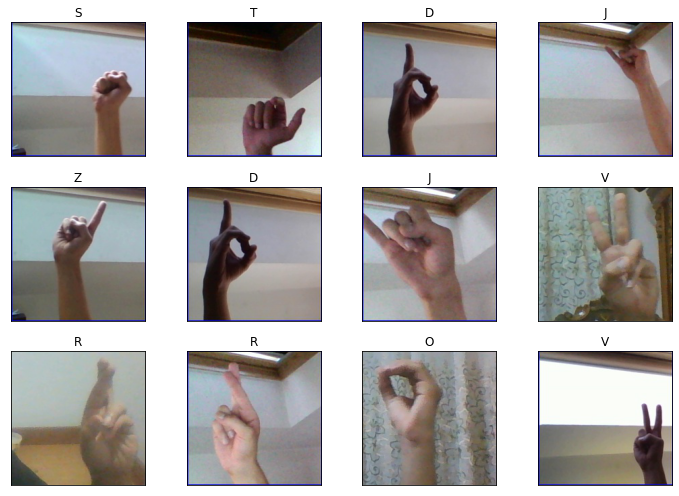

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.FilePath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

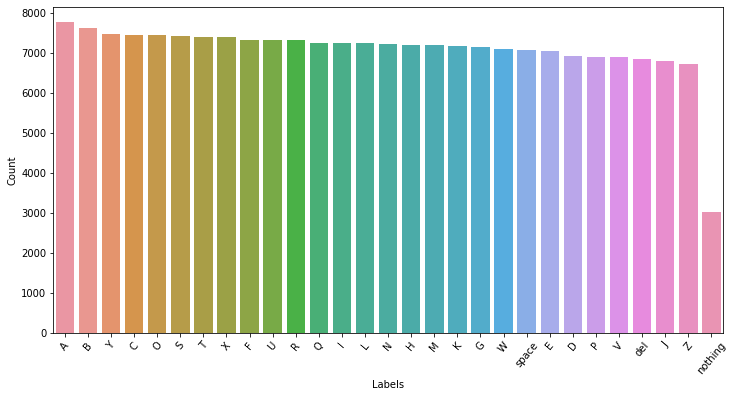

In [7]:
plt.figure(figsize=(12, 6))
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

# Train & Test Split

In [8]:
train_df, test_df = train_test_split(data, train_size=0.7, random_state=1)

# Functions

In [9]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='FilePath',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [10]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(120, activation='relu')(pre_model.output)
    x = Dense(120, activation='relu')(x)
    outputs = Dense(29, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [11]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Label,pred)
    clr = classification_report(test_df.Label, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.FilePath.iloc[i+1]))
        ax.set_title(f"True: {test_df.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [12]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

# ResNet50

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df, test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [14]:
ResNet50_model, callback=func(ResNet50)

2021-10-16 19:22:16.021838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 19:22:16.111555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 19:22:16.112438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 19:22:16.113938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=50,
    callbacks=callback
)

2021-10-16 19:22:21.191617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-10-16 19:22:25.788165: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3587/3587 [==============================] - 1524s 422ms/step - loss: 0.4209 - accuracy: 0.8693 - val_loss: 0.1951 - val_accuracy: 0.9369
Epoch 2/50
3587/3587 [==============================] - 460s 128ms/step - loss: 0.1530 - accuracy: 0.9504 - val_loss: 0.1244 - val_accuracy: 0.9587
Epoch 3/50
3587/3587 [==============================] - 507s 141ms/step - loss: 0.1142 - accuracy: 0.9626 - val_loss: 0.1157 - val_accuracy: 0.9642
Epoch 4/50
3587/3587 [==============================] - 519s 145ms/step - loss: 0.0954 - accuracy: 0.9691 - val_loss: 0.1038 - val_accuracy: 0.9697
Epoch 5/50
3587/3587 [==============================] - 514s 143ms/step - loss: 0.0789 - accuracy: 0.9748 - val_loss: 0.1040 - val_accuracy: 0.9703


              precision    recall  f1-score   support

           A       0.97      0.98      0.98      2372
           B       0.94      0.99      0.97      2285
           C       0.99      0.96      0.98      2267
           D       0.96      0.98      0.97      2013
           E       0.96      0.98      0.97      2132
           F       0.95      0.98      0.97      2205
           G       0.94      0.99      0.96      2175
           H       0.99      0.95      0.97      2150
           I       0.98      0.95      0.96      2132
           J       1.00      0.96      0.98      2044
           K       0.98      0.97      0.97      2152
           L       0.96      0.98      0.97      2169
           M       0.97      0.98      0.97      2196
           N       0.98      0.98      0.98      2165
           O       1.00      0.96      0.98      2246
           P       0.97      1.00      0.98      2123
           Q       0.97      0.99      0.98      2211
           R       0.98    

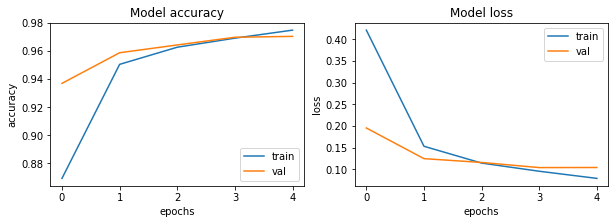

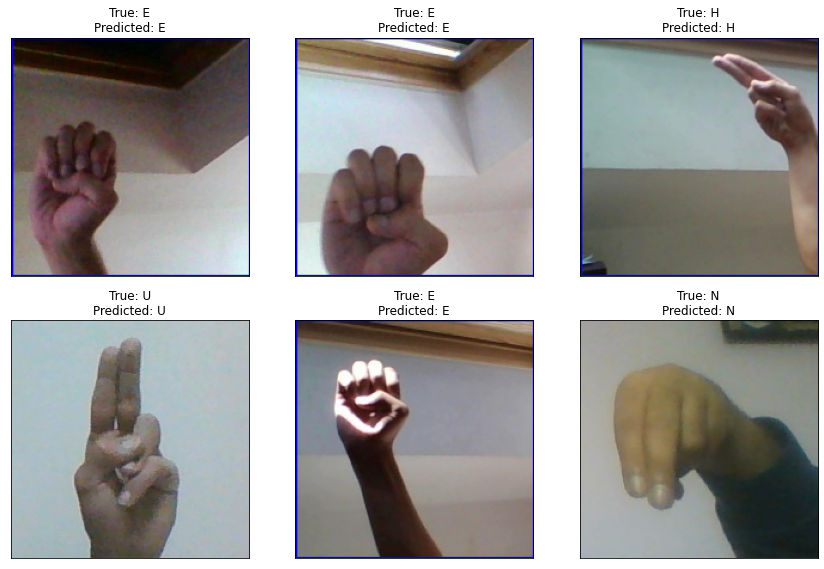

In [16]:
history_ResNet=plot(history,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [17]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.10910
Test Accuracy: 96.92%


# MobileNet

In [18]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [19]:
MobileNet_model, callback=func(MobileNet)

17235968/17225924 [==============================] - 0s 0us/step


In [20]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
3587/3587 [==============================] - 510s 142ms/step - loss: 0.2967 - accuracy: 0.9103 - val_loss: 0.1172 - val_accuracy: 0.9616
Epoch 2/100
3587/3587 [==============================] - 474s 132ms/step - loss: 0.0991 - accuracy: 0.9682 - val_loss: 0.1138 - val_accuracy: 0.9649
Epoch 3/100
3587/3587 [==============================] - 469s 131ms/step - loss: 0.0744 - accuracy: 0.9764 - val_loss: 0.1617 - val_accuracy: 0.9585


              precision    recall  f1-score   support

           A       0.94      0.98      0.96      2372
           B       0.98      0.95      0.97      2285
           C       0.98      0.99      0.98      2267
           D       0.99      0.96      0.97      2013
           E       0.98      0.93      0.95      2132
           F       0.98      0.98      0.98      2205
           G       0.99      0.97      0.98      2175
           H       0.97      0.98      0.98      2150
           I       0.99      0.87      0.93      2132
           J       0.99      0.94      0.97      2044
           K       0.96      0.90      0.93      2152
           L       0.93      0.99      0.96      2169
           M       0.99      0.95      0.97      2196
           N       0.96      0.99      0.98      2165
           O       0.95      0.99      0.97      2246
           P       1.00      0.97      0.99      2123
           Q       0.99      0.98      0.98      2211
           R       1.00    

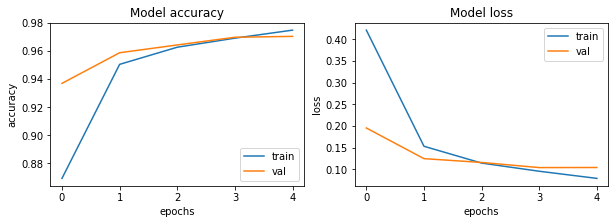

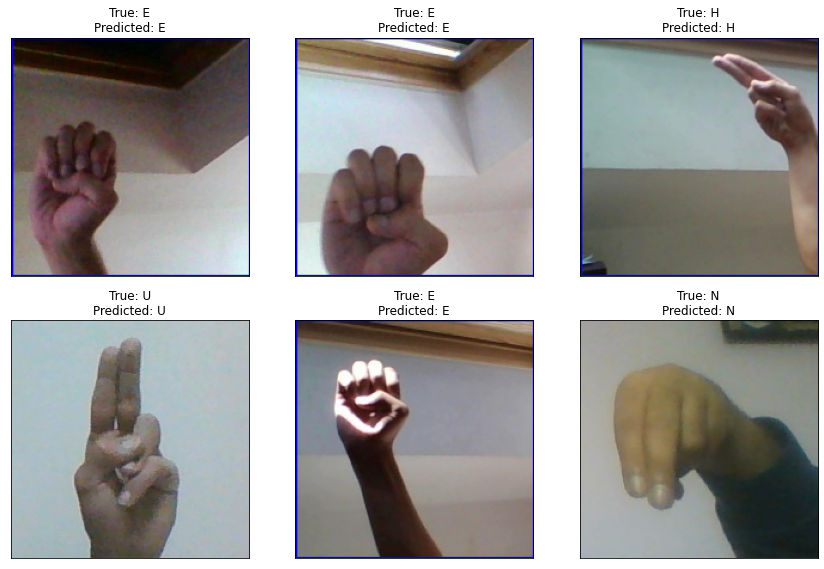

In [21]:
history=plot(history,test_gen_MobileNet,train_gen_MobileNet,MobileNet_model)

In [22]:
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

    Test Loss: 0.16620
Test Accuracy: 95.74%


# VGG16

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [24]:
model_VGG16, callback=func(VGG16)

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
3587/3587 [==============================] - 529s 147ms/step - loss: 0.3906 - accuracy: 0.8878 - val_loss: 0.1391 - val_accuracy: 0.9569
Epoch 2/100
3587/3587 [==============================] - 508s 142ms/step - loss: 0.1188 - accuracy: 0.9631 - val_loss: 0.0812 - val_accuracy: 0.9750
Epoch 3/100
3587/3587 [==============================] - 482s 134ms/step - loss: 0.0844 - accuracy: 0.9738 - val_loss: 0.0756 - val_accuracy: 0.9782
Epoch 4/100
3587/3587 [==============================] - 479s 134ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.0996 - val_accuracy: 0.9718


              precision    recall  f1-score   support

           A       0.97      0.98      0.98      2372
           B       0.99      0.96      0.97      2285
           C       0.98      0.98      0.98      2267
           D       0.97      0.96      0.97      2013
           E       0.98      0.94      0.96      2132
           F       0.98      0.97      0.98      2205
           G       0.98      0.94      0.96      2175
           H       0.96      0.99      0.97      2150
           I       0.98      0.96      0.97      2132
           J       0.98      0.98      0.98      2044
           K       0.99      0.96      0.97      2152
           L       0.99      0.95      0.97      2169
           M       0.97      0.95      0.96      2196
           N       0.97      0.99      0.98      2165
           O       0.98      0.98      0.98      2246
           P       0.95      0.99      0.97      2123
           Q       0.99      0.99      0.99      2211
           R       0.95    

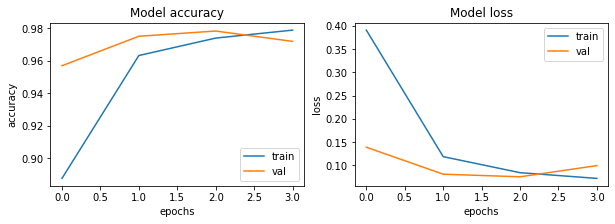

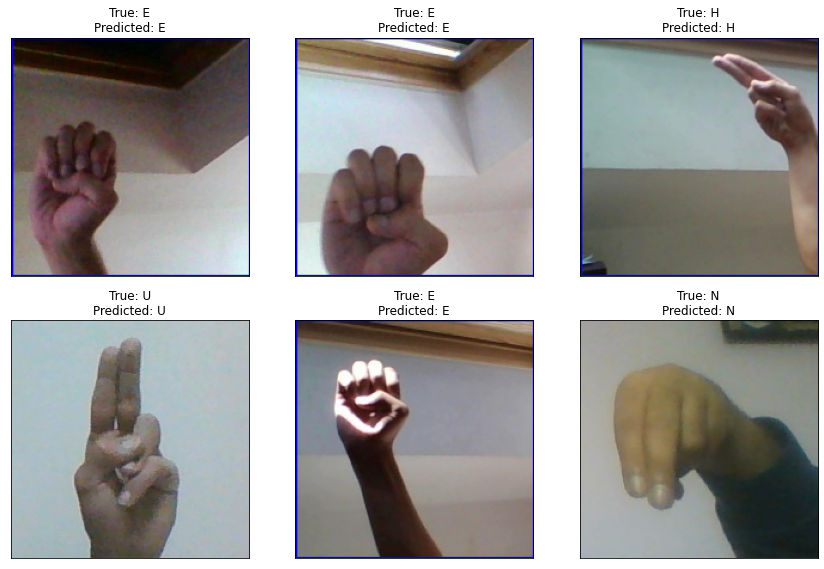

In [26]:
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)

In [27]:
result = result_test(test_gen_VGG,model_VGG16)

    Test Loss: 0.10889
Test Accuracy: 97.07%


# Xception

In [28]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
Xception_pre=preprocess_input
train_gen_Xception, valid_gen_Xception, test_gen_Xception = gen(Xception_pre,train_df,test_df)

Found 114757 validated image filenames belonging to 29 classes.
Found 28689 validated image filenames belonging to 29 classes.
Found 61478 validated image filenames belonging to 29 classes.


In [29]:
Xception_model, callback=func(Xception)

83697664/83683744 [==============================] - 0s 0us/step


In [30]:
history = Xception_model.fit(
    train_gen_Xception,
    validation_data=valid_gen_Xception,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
3587/3587 [==============================] - 508s 141ms/step - loss: 0.5774 - accuracy: 0.8292 - val_loss: 0.2549 - val_accuracy: 0.9216
Epoch 2/100
3587/3587 [==============================] - 492s 137ms/step - loss: 0.1966 - accuracy: 0.9382 - val_loss: 0.1659 - val_accuracy: 0.9489
Epoch 3/100
3587/3587 [==============================] - 449s 125ms/step - loss: 0.1318 - accuracy: 0.9579 - val_loss: 0.1497 - val_accuracy: 0.9549
Epoch 4/100
3587/3587 [==============================] - 481s 134ms/step - loss: 0.1049 - accuracy: 0.9663 - val_loss: 0.1218 - val_accuracy: 0.9637
Epoch 5/100
3587/3587 [==============================] - 504s 140ms/step - loss: 0.0851 - accuracy: 0.9728 - val_loss: 0.1360 - val_accuracy: 0.9638


              precision    recall  f1-score   support

           A       0.95      0.97      0.96      2372
           B       0.98      0.95      0.97      2285
           C       0.99      0.98      0.98      2267
           D       0.94      0.97      0.95      2013
           E       0.97      0.94      0.96      2132
           F       0.99      0.95      0.97      2205
           G       0.95      0.98      0.96      2175
           H       0.98      0.97      0.98      2150
           I       0.94      0.96      0.95      2132
           J       0.95      0.99      0.97      2044
           K       0.99      0.92      0.95      2152
           L       0.95      0.97      0.96      2169
           M       0.98      0.96      0.97      2196
           N       0.96      0.96      0.96      2165
           O       0.93      0.98      0.96      2246
           P       0.98      0.98      0.98      2123
           Q       0.98      0.99      0.99      2211
           R       0.95    

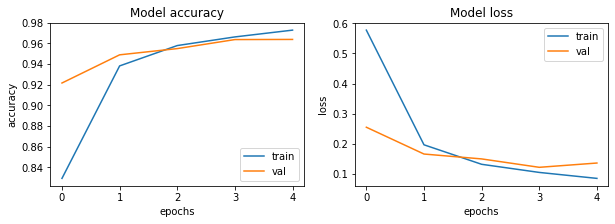

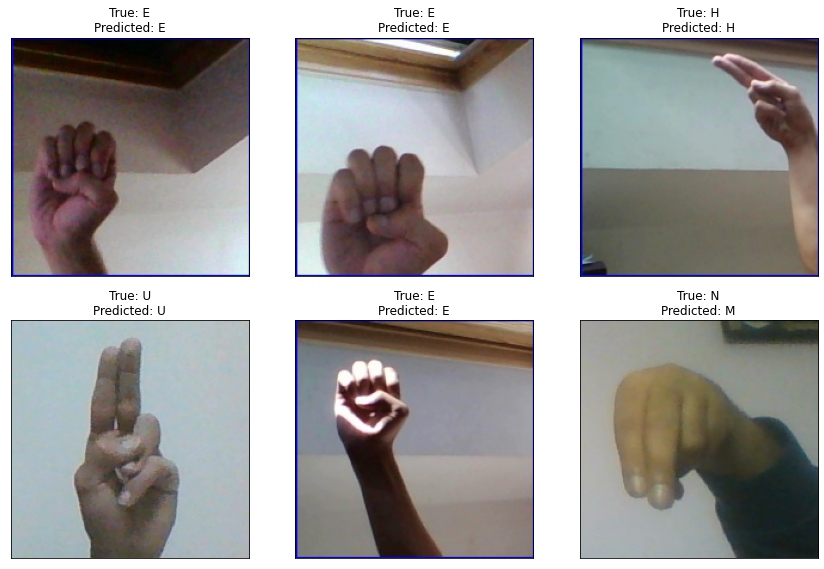

In [31]:
history_Xception=plot(history,test_gen_Xception,train_gen_Xception, Xception_model)

In [32]:
result_Xception = result_tresult_Xception = result_test(test_gen_Xception,Xception_model)

    Test Loss: 0.13875
Test Accuracy: 96.30%


# Final Report

In [33]:
output = pd.DataFrame({'Model':['VGG16','ResNet50','Xception','MobileNet'],
                      'Accuracy':[result[1], result_ResNet[1], result_Xception[1], result_MobileNet[1]]})

In [34]:
output

,Model,Accuracy
0,VGG16,0.970705
1,ResNet50,0.969208
2,Xception,0.963044
3,MobileNet,0.957367


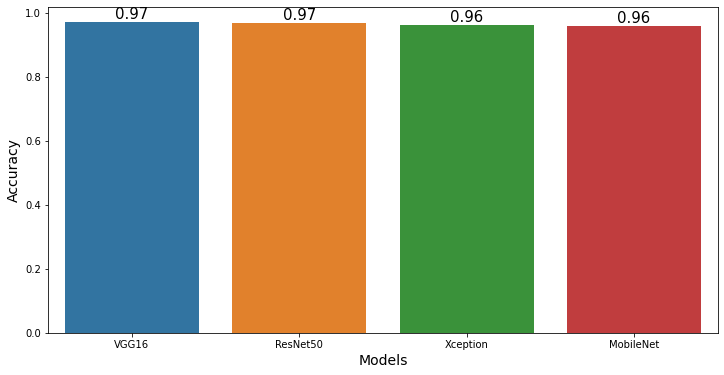

In [35]:
plt.figure(figsize=(12, 6))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()

# Thanks

* Feel free to download Notebook and do experiments on it.
* Comments if you find something inappropriate and will improve accordingly.
* Upvote if you find this notebook useful.